# log Beta function approximation

## Stirling's approximation to `lgamma`
Consider Stirling's approximation to the `lgamma` function
```
lgamma(z) ~ (z - 1/2) * log(z) - z + log(2 * pi) / 2
```
We can amplify Stirling's approximation via the recursion
```
lgamma(z + 1) = lgamma(z) + log(z)
```
Now since Stirling's approximation is more accurate for large `z`, we can increment small `z`
```
lgamma(z) = lgamma(z+1) - log(z)
          = lgamma(z+2) - log(z * (z+1))
          = lgamma(z+3) - log(z * (z+1) * (z+2))
          = ...
```

In [1]:
import math
import operator
from functools import reduce

import torch
import matplotlib.pyplot as plt

In [2]:
def lgamma_approx(x, shift=0):
    if shift > 0:
        factor = reduce(operator.mul, [x + i for i in range(shift)])
        return lgamma_approx(x + shift) - factor.log()
    return (x - 0.5) * x.log() - x + math.log(2 * math.pi) / 2

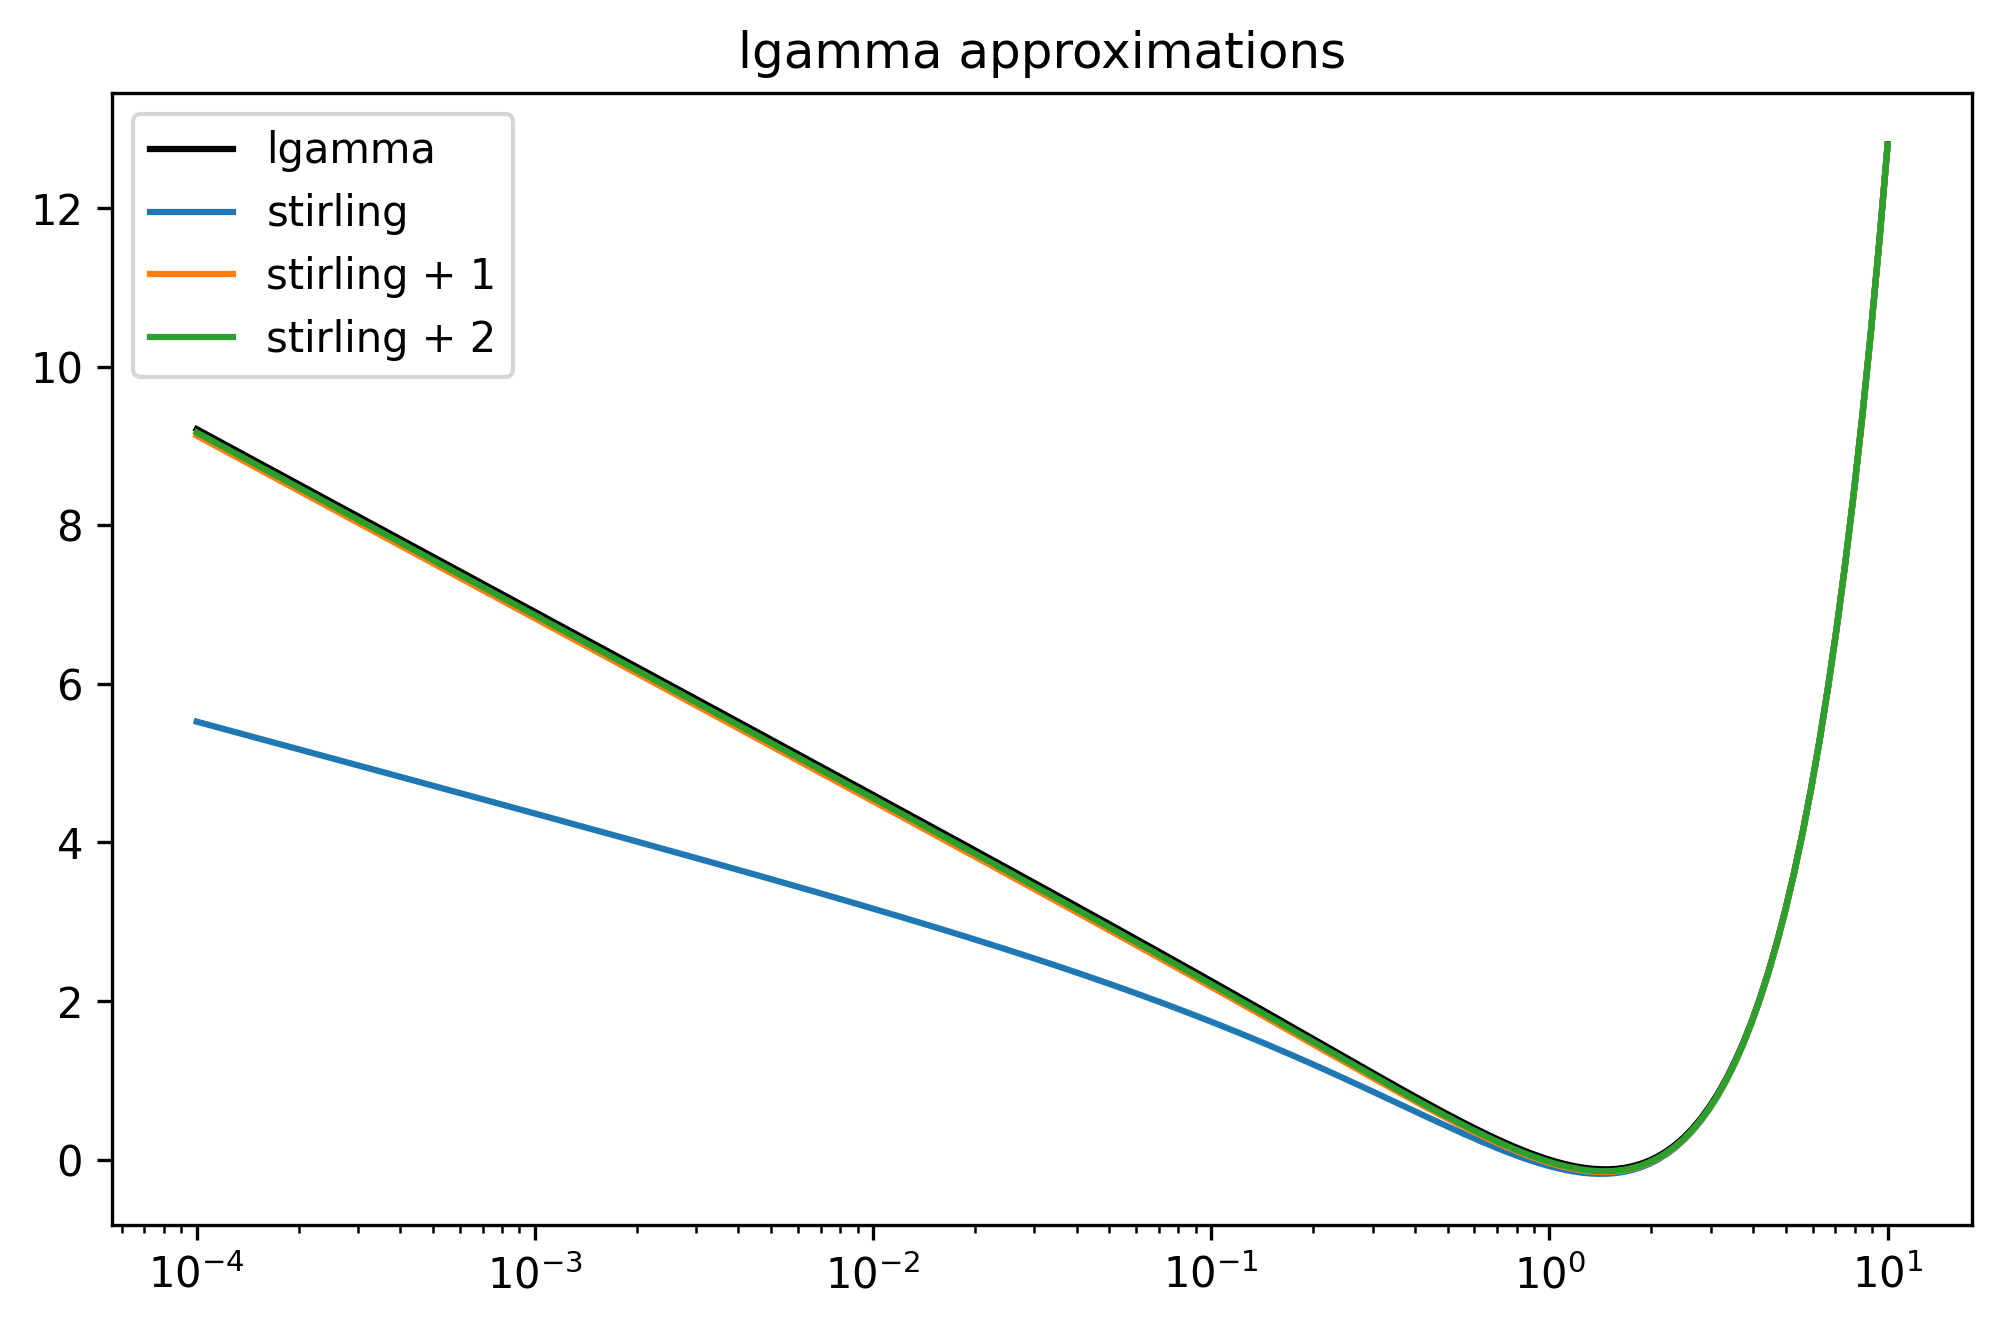

In [3]:
plt.figure(figsize=(8, 5), dpi=300).patch.set_color("white")
x = torch.logspace(-4, 1, 200)
plt.plot(x, x.lgamma(), 'k-', label="lgamma")
plt.plot(x, lgamma_approx(x), label="stirling")
plt.plot(x, lgamma_approx(x, 1), label="stirling + 1")
plt.plot(x, lgamma_approx(x, 2), label="stirling + 2")
plt.xscale("log")
plt.legend(loc="best")
plt.title("lgamma approximations");

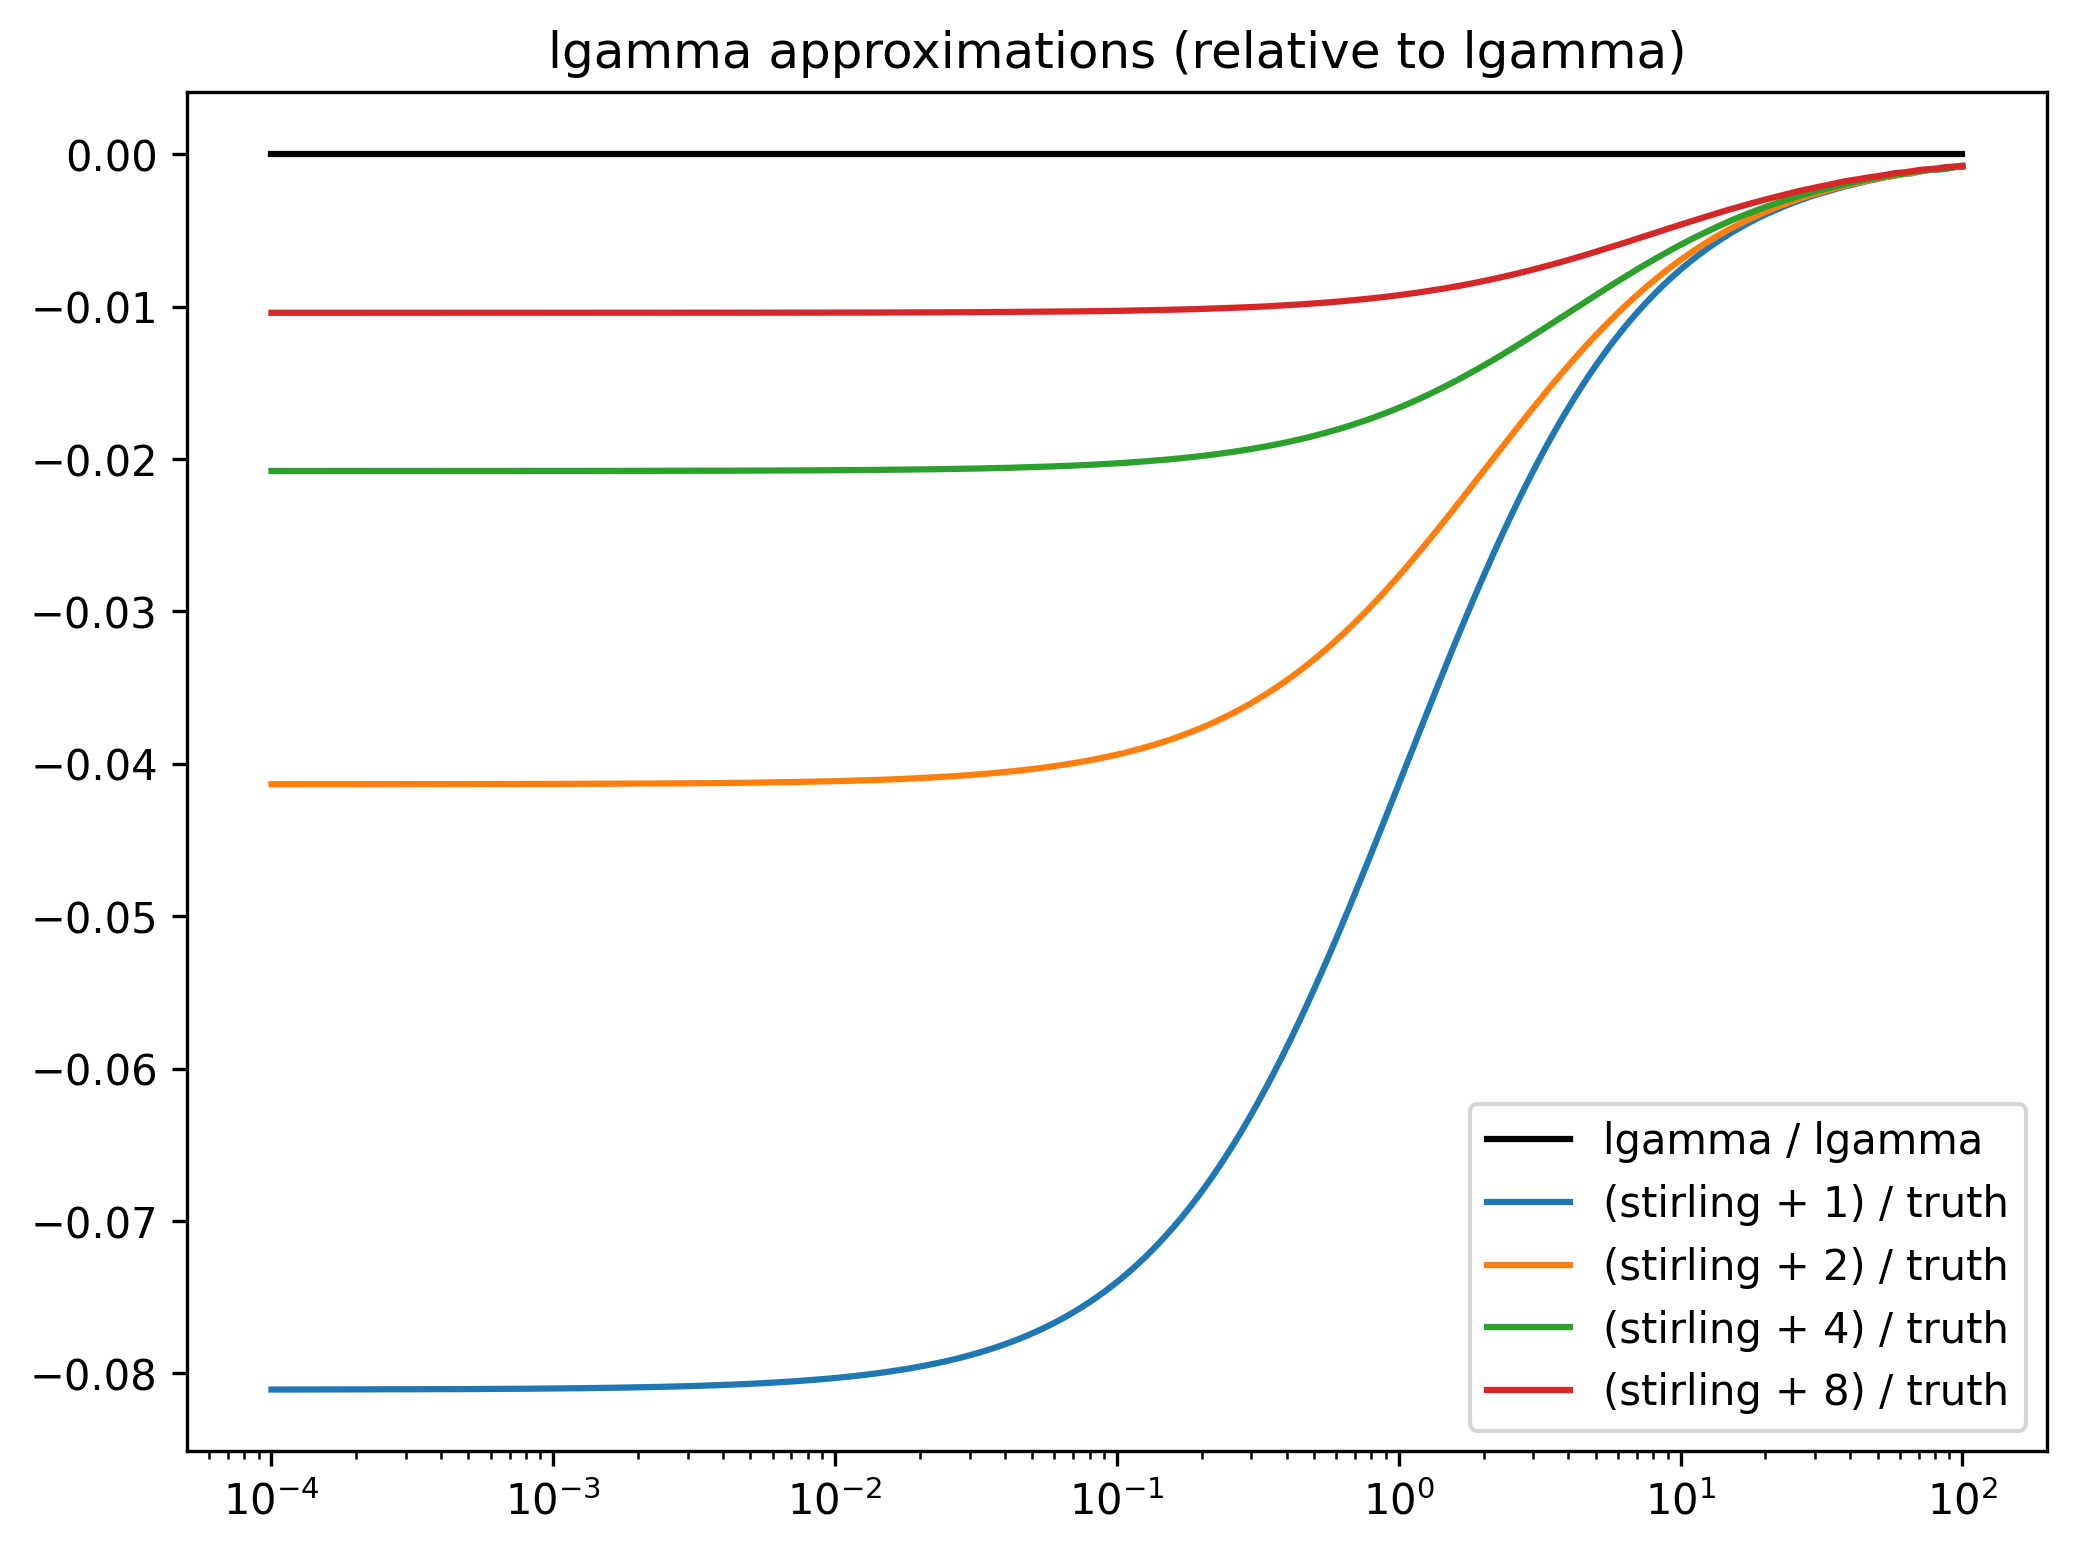

In [4]:
plt.figure(figsize=(8, 6), dpi=300).patch.set_color("white")
x = torch.logspace(-4, 2, 200)
plt.plot(x, 0 * x, 'k-', label="lgamma / lgamma")
#plt.plot(x, lgamma_approx(x) - x.lgamma(), label="stirling / truth")
plt.plot(x, lgamma_approx(x, 1) - x.lgamma(), label="(stirling + 1) / truth")
plt.plot(x, lgamma_approx(x, 2) - x.lgamma(), label="(stirling + 2) / truth")
plt.plot(x, lgamma_approx(x, 4) - x.lgamma(), label="(stirling + 4) / truth")
plt.plot(x, lgamma_approx(x, 8) - x.lgamma(), label="(stirling + 8) / truth")
plt.xscale("log")
plt.legend(loc="best")
plt.title("lgamma approximations (relative to lgamma)");

## Stirling's approximation to Beta function
The log Beta function is defined as
```
lbeta(x, y) = lgamma(x) + lgamma(y) - lgamma(x + y)
```
Applying Stirling's approximation to the `lbeta` function we have
```
lbeta(x, y) ~ ((x-1/2) * log(x) + (y-1/2) * log(y)
               - (x+y-1/2) * log(x+y) + log(2*pi)/2)
```

In [5]:
def lbeta(x, y):
    return x.lgamma() + y.lgamma() - (x + y).lgamma()

def lbeta_approx(x, y):
    return ((x - 0.5) * x.log() + (y - 0.5) * y.log()
            - (x + y - 0.5) * (x + y).log() + math.log(2*math.pi) / 2)

def lbeta_approx_i(x, y, shift=0):
    xy = x + y
    factors = []
    for _ in range(shift):
        factors.append(xy / (x * y))
        x = x + 1
        y = y + 1
        xy = xy + 1
    log_factor = reduce(operator.mul, factors).log() if factors else 0
    return (log_factor + (x - 0.5) * x.log() + (y - 0.5) * y.log()
            - (xy - 0.5) * xy.log() + (math.log(2*math.pi) / 2 - shift))

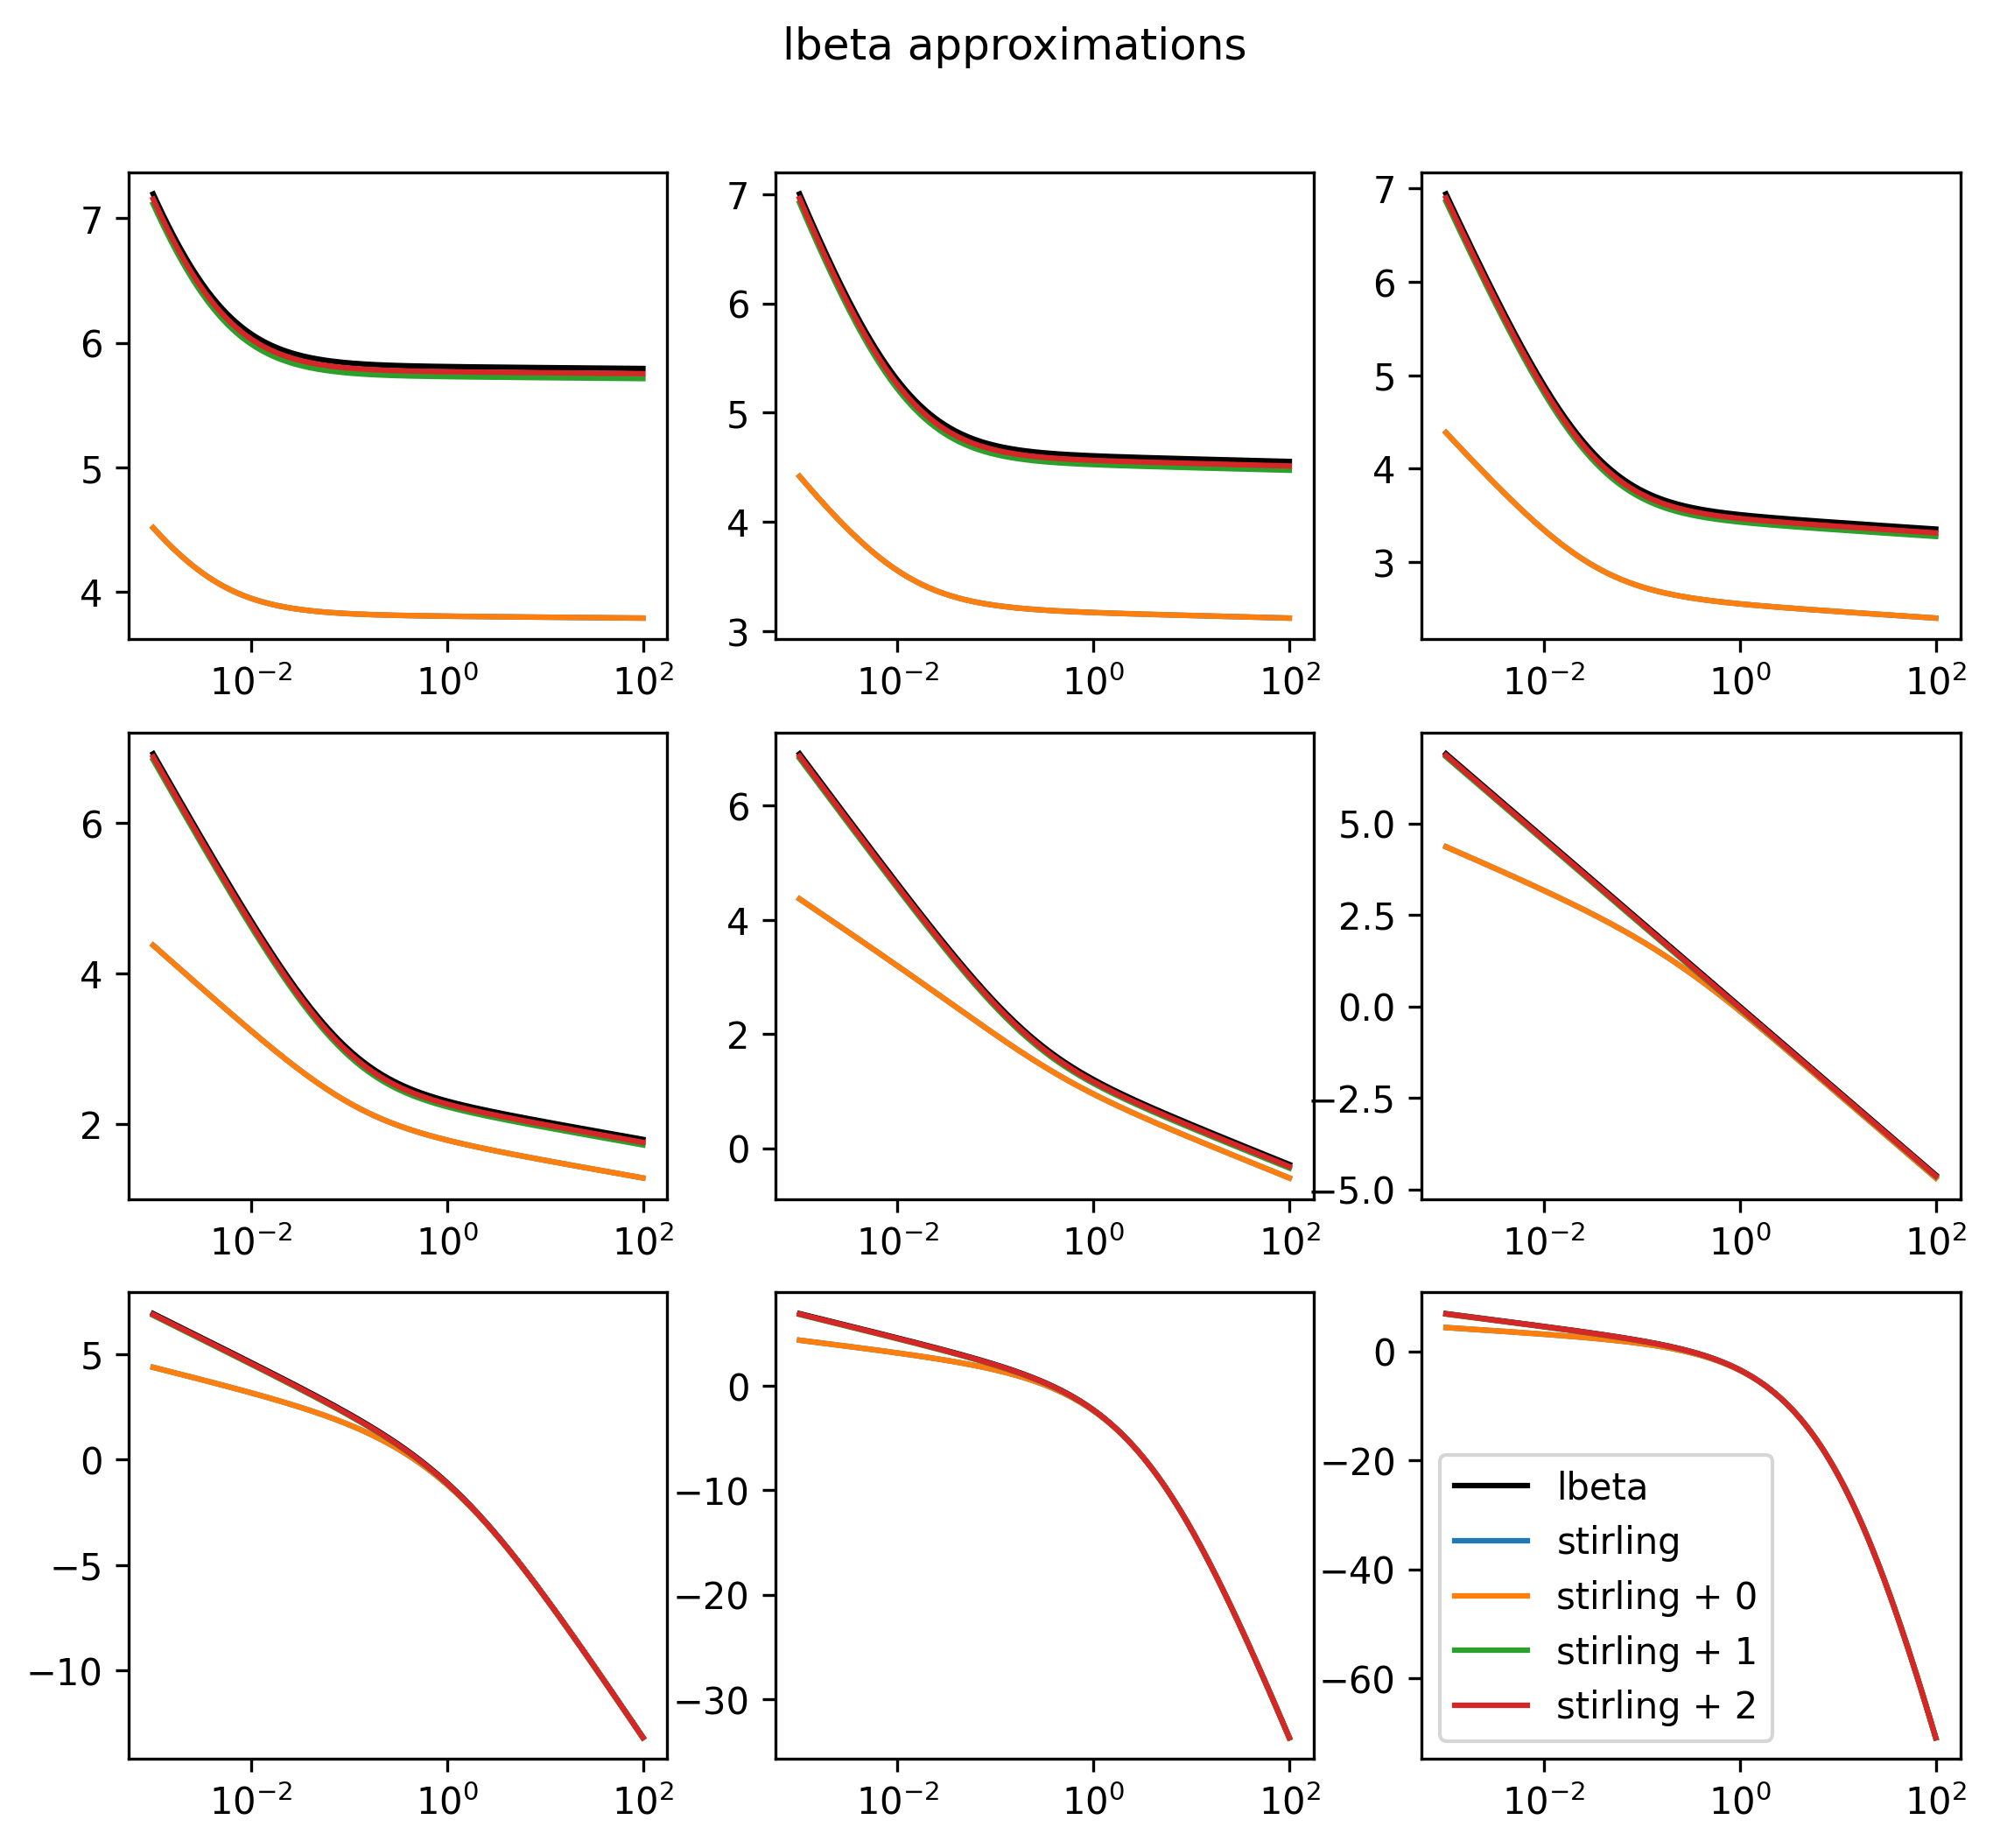

In [6]:
fig, axes = plt.subplots(3, 3, figsize=(9, 8), dpi=300)
fig.patch.set_color("white")
x = torch.logspace(-3, 2, 200)
ys = torch.tensor([0.003, 0.01, 0.03, 0.1, 0.3, 1.0, 3.0, 10., 30.])
axes = [axes[i][j] for i in range(3) for j in range(3)]
for ax, y in zip(axes, ys):
    ax.plot(x, lbeta(x, y), 'k-', label="lbeta".format(y.item()))
    ax.plot(x, lbeta_approx(x, y), label="stirling")
    ax.plot(x, lbeta_approx_i(x, y, 0), label="stirling + 0")
    ax.plot(x, lbeta_approx_i(x, y, 1), label="stirling + 1")
    ax.plot(x, lbeta_approx_i(x, y, 2), label="stirling + 2")
    ax.set_xscale("log")
axes[-1].legend(loc="best")
fig.suptitle("lbeta approximations", y=0.95);

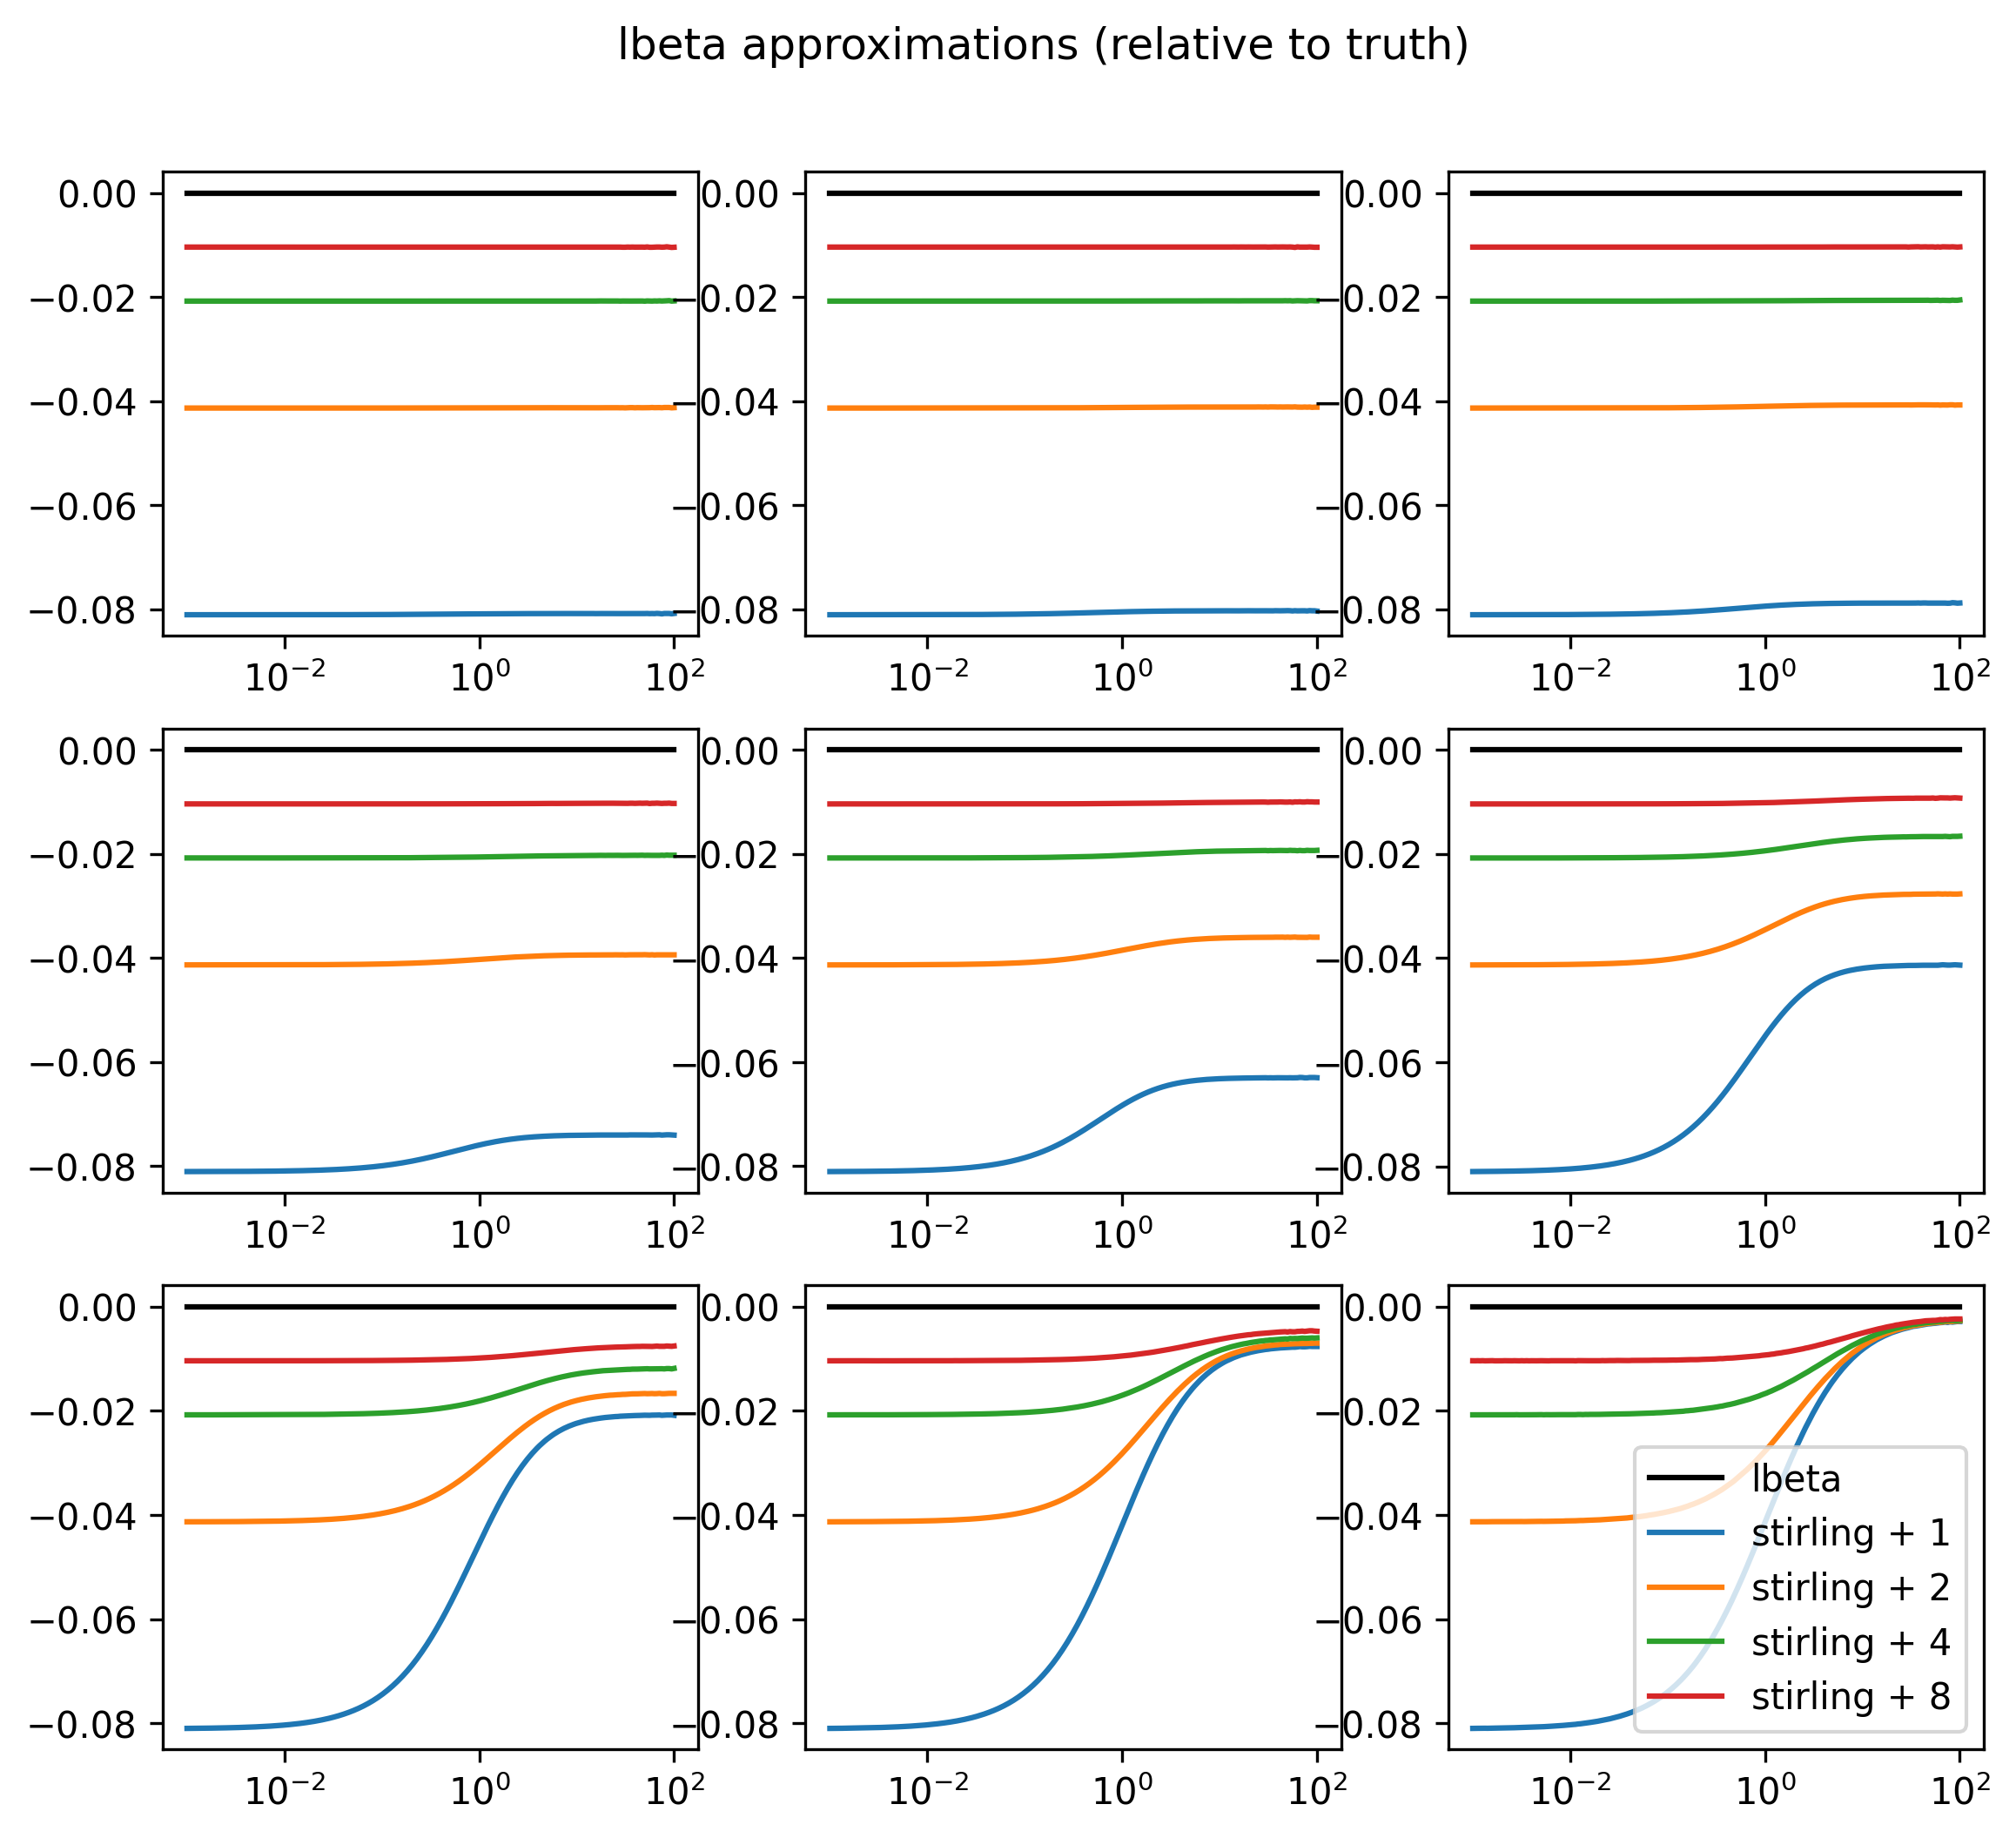

In [7]:
fig, axes = plt.subplots(3, 3, figsize=(9, 8), dpi=300)
fig.patch.set_color("white")
x = torch.logspace(-3, 2, 200)
ys = torch.tensor([0.003, 0.01, 0.03, 0.1, 0.3, 1.0, 3.0, 10., 30.])
axes = [axes[i][j] for i in range(3) for j in range(3)]
for ax, y in zip(axes, ys):
    truth = lbeta(x, y)
    ax.plot(x, 0 * x, 'k-', label="lbeta".format(y.item()))
    ax.plot(x, lbeta_approx_i(x, y, 1) - truth, label="stirling + 1")
    ax.plot(x, lbeta_approx_i(x, y, 2) - truth, label="stirling + 2")
    ax.plot(x, lbeta_approx_i(x, y, 4) - truth, label="stirling + 4")
    ax.plot(x, lbeta_approx_i(x, y, 8) - truth, label="stirling + 8")
    ax.set_xscale("log")
axes[-1].legend(loc="best")
fig.suptitle("lbeta approximations (relative to truth)", y=0.95);

In [8]:
x = torch.tensor(1e-8)
y = torch.tensor(1.)
print((lbeta(x, x) - lbeta_approx_i(x, x, 1)).item())
print((lbeta(x, y) - lbeta_approx_i(x, y, 1)).item())
print((lbeta(y, y) - lbeta_approx_i(y, y, 1)).item())

0.08106231689453125
0.08106231689453125
0.05500350892543793


## Implementation

In [9]:
from pyro.ops.special import log_beta, log_beta_stirling

In [10]:
n = int(1e6)
x = torch.randn(n).exp().requires_grad_()
y = torch.randn(n).exp().requires_grad_()

In [11]:
%%timeit
log_beta(x, y).sum().backward()

116 ms ± 1.88 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [12]:
%%timeit
log_beta_stirling(x, y, tol=0.1).sum().backward()

46.4 ms ± 945 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [13]:
%%timeit
log_beta_stirling(x, y, tol=0.05).sum().backward()

73.7 ms ± 836 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [14]:
%%timeit
log_beta_stirling(x, y, tol=0.02).sum().backward()

171 ms ± 4.12 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


This final run should defer to exact `log_beta()`.

In [15]:
%%timeit
log_beta_stirling(x, y, tol=0.01).sum().backward()

143 ms ± 3.09 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
